## Notebook to analyze biosynthetic pathways and reactions fluxes for secondary metabolites in EcN

In [253]:
import cobra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cameo
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from cameo import phenotypic_phase_plane
from cameo.strain_design.deterministic import DifferentialFVA
from cameo.strain_design import OptGene
import numpy as np
from scipy.stats import linregress
import plotly.express as px
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
from cobra.flux_analysis import flux_variability_analysis
import os

In [178]:
#Establish a definition that initializes models to an in silico representation of gut microbiome media
def M1(model):
    
    medium = model.medium
    
    # Set exchange to zero
    for rxn in medium:
        medium[rxn] = 0.0 # Remove all current media components

    # Read medias - FROM AGORA
    media_db = pd.read_table("../tables/media_db.txt", comment="#")
    media_db["compound"] = [cpd.strip() for cpd in media_db["compound"]]
    media_db = media_db[["medium", "compound"]].groupby("medium").agg(lambda x: list(x)).to_dict()['compound']


    # Add compounds to media composition
    for compound in media_db['M1']: # M1 > Gut microbium media, GMM
        try:
            model.reactions.get_by_id('EX_%s_e'%compound)
            medium['EX_%s_e'%compound]= 1000
        except:
#             print(compound, 'is missing in the model')
            pass
    
    medium['EX_o2_e']= 1000 # Make aerobic, so we can analyse the differences between aerobic and anaerobic
        
    # Update medium
    model.medium = medium
    
    return model

In [179]:
# load model with sec mets
EcN_model = cobra.io.load_json_model('../data/models/CP022686.1_cur_4.8.json')
df_sec_met_rxn = pd.read_csv('../tables/sec_met_paths_reactions.csv', index_col='ID', sep=';')
# EcN_model.summary()
M1(EcN_model)
with EcN_model as model:
    pfba_solution_WT = cobra.flux_analysis.pfba(model)
df_reactions = pd.read_csv('../tables/CP022686.1_cur_4.8_reactions_info.csv', index_col='ID')    

In [180]:
EcN_model = M1(EcN_model)
EcN_model.summary()

In [185]:
EcN_model = M1(EcN_model)
target_exchange_dict = dict({'Yersiniabactin': 'EX_ybt_e', 
                   'Colibactin': 'EX_clbtn_e', 
                   'Enterobactin': 'EX_enter_e',
                   'Salmochelin': 'EX_salchsx_e',
                    'Aerobactin': 'EX_arbtn_e'})

pfba_matrix = pd.DataFrame(index=pfba_solution_WT.to_frame().index.tolist())
pfba_matrix['fluxes:WT'] = pfba_solution_WT.to_frame()['fluxes']

for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met] 
    with EcN_model as model:
        model.objective = target_exchange
        pfba_solution_tgt = cobra.flux_analysis.pfba(model)
        # print(model.summary())
        print('Maximum flux through', target_exchange, pfba_solution_tgt[target_exchange])
        pfba_matrix['fluxes:' + sec_met] = pfba_solution_tgt.to_frame().loc[pfba_matrix.index,'fluxes']
        with EcN_model as model:
            model.reactions.get_by_any("BIOMASS_EcN_iHM1533_core_59p80M")[0].upper_bound = 20
            model.reactions.get_by_any("BIOMASS_EcN_iHM1533_core_59p80M")[0].lower_bound = 20
            pfba_solution_tgt = cobra.flux_analysis.pfba(model)
            print('Maximum flux through', target_exchange, pfba_solution_tgt[target_exchange])

Maximum flux through EX_ybt_e 109.66395604395599
Maximum flux through EX_ybt_e 56.773084600121294
Maximum flux through EX_clbtn_e 48.966646646646595
Maximum flux through EX_clbtn_e 26.167447035747315
Maximum flux through EX_enter_e 111.61213572854282
Maximum flux through EX_enter_e 60.49787634768018
Maximum flux through EX_salchsx_e 237.60523809523843
Maximum flux through EX_salchsx_e 122.86080219278979
Maximum flux through EX_arbtn_e 211.92518297236737
Maximum flux through EX_arbtn_e 118.46242144849268


In [42]:
p = phenotypic_phase_plane(EcN_model, variables=['BIOMASS_EcN_iHM1533_core_59p80M'], objective='EX_enter_e', points=10)
df_sec_met_all = p.data_frame.reindex(columns = ['BIOMASS_EcN_iHM1533_core_59p80M'])

for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met] 
    with EcN_model as model:
        model.objective = target_exchange
        p_sec_met = phenotypic_phase_plane(EcN_model, variables=['BIOMASS_EcN_iHM1533_core_59p80M'], objective=target_exchange, points=10)
        df_sec_met = p_sec_met.data_frame.copy()
        df_sec_met_all[target_exchange] = df_sec_met['objective_upper_bound']

df_sec_met_all.set_index('BIOMASS_EcN_iHM1533_core_59p80M', inplace=True)

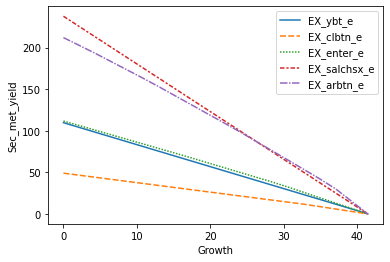

In [181]:
plt.figure()
ax = sns.lineplot(data=df_sec_met_all)
plt.xlabel('Growth')
plt.ylabel('Sec_met_yield')
plt.show()

## FSEOF

In [49]:
fseof = FSEOF(EcN_model)

In [50]:
df_fseof_tgt_slopes = pd.DataFrame(columns=target_exchange_dict.keys())
fseof_dict = dict()

ignore_rxn = df_sec_met_rxn.index.tolist()
ignore_rxn = ignore_rxn + ['H2Otpp', 'CO2tex', 'CO2tpp', 'H2Otex', 'ATPS4rpp', 'NADH16pp','CYTBO3_4pp',
                           'GLCtex', 'GLCptspp', 'THD2pp','Htex', 'FORtex','FORtppi'] + list(target_exchange_dict.values())

cutoff = 1e-3
df_diff_2 = pd.DataFrame(columns=target_exchange_dict.keys())
df_diff_1 = pd.DataFrame(columns=target_exchange_dict.keys())

for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met] 
    results_tgt = fseof.run(target=target_exchange, exclude=ignore_rxn, number_of_results=30)
    df_fseof_tgt = results_tgt.data_frame         
    
    for row in df_fseof_tgt.index:
        if row not in ignore_rxn:
            flux_range = df_fseof_tgt.loc[row,:]
            linreg = linregress(df_fseof_tgt.loc[target_exchange,:], flux_range)
            slope = linreg.slope
            df_fseof_tgt_slopes.loc[row, sec_met] = slope
            
            diff_1 = df_fseof_tgt.T[row].diff()
            diff_2 = df_fseof_tgt.T[row].diff().diff()
            
            if len(diff_1[(diff_1 > cutoff)]) > 0:
                df_diff_1.loc[row, sec_met] = 'positive'
            elif len(diff_1[(diff_1 < -1*cutoff)]) > 0:
                df_diff_1.loc[row, sec_met] = 'negative'
            else:
                df_diff_1.loc[row, sec_met] = 'zero'
                
            if len(diff_2[(diff_2 > cutoff)]) > 0:
                df_diff_2.loc[row, sec_met] = 'positive'
            elif len(diff_2[(diff_2 < -1*cutoff)]) > 0:
                df_diff_2.loc[row, sec_met] = 'negative'
            else:
                df_diff_2.loc[row, sec_met] = 'zero'
    fseof_dict[sec_met] = df_fseof_tgt            

In [53]:
df_subsys_rxns = pd.DataFrame(columns=fseof_dict.keys())
    
for sec_met in fseof_dict.keys():
    df = fseof_dict[sec_met].T
    df_fseof_rxns = pd.DataFrame(columns=df_reactions.columns)
    for rxn_id in df.columns:
        if rxn_id in df_reactions.index:
            df_fseof_rxns.loc[rxn_id, :] = df_reactions.loc[rxn_id, :]
    df_count = df_fseof_rxns.groupby('Subsystem').count()
    for subsys in df_count.index:
        if not subsys in df_subsys_rxns.index:
            df_subsys_rxns.loc[subsys, :] = 0
            # print(subsys, df_count)
            df_subsys_rxns.loc[subsys, sec_met] = df_count.loc[subsys, 'Name']
        else:
            df_subsys_rxns.loc[subsys, sec_met] = df_count.loc[subsys, 'Name']
    
df_subsys_rxns[df_subsys_rxns>4].dropna(how='all').index.tolist()

['Alternate Carbon Metabolism',
 'Citric Acid Cycle',
 'Cofactor and Prosthetic Group Biosynthesis',
 'Glycolysis/Gluconeogenesis',
 'Inorganic Ion Transport and Metabolism',
 'Membrane Lipid Metabolism',
 'Methionine Metabolism',
 'Nucleotide Salvage Pathway',
 'Oxidative Phosphorylation',
 'Pentose Phosphate Pathway',
 'Pyruvate Metabolism',
 'Transport, Inner Membrane',
 'Transport, Outer Membrane',
 'Tyrosine, Tryptophan, and Phenylalanine Metabolism',
 'Threonine and Lysine Metabolism']

In [54]:
subsystem_list = ['Alternate Carbon Metabolism',
 'Cofactor and Prosthetic Group Biosynthesis',
 'Glycolysis/Gluconeogenesis',
 'Membrane Lipid Metabolism',
 'Nucleotide Salvage Pathway',
 'Pentose Phosphate Pathway',
 'Transport, Outer Membrane Porin',
 'Other']
color_dict = dict(zip(subsystem_list, px.colors.qualitative.Plotly))
color_dict['Other'] = '#8f9194'

amino_path_list= ['Cysteine Metabolism',
                 'Methionine Metabolism',
                 'Threonine and Lysine Metabolism',
                'Valine, Leucine, and Isoleucine Metabolism',
                  'Threonine and Lysine Metabolism',
                  'Glutamate Metabolism',
                  'Arginine and Proline Metabolism',
                  'Alanine and Aspartate Metabolism',
                  'Tyrosine, Tryptophan, and Phenylalanine Metabolism',
                  'Glycine and Serine Metabolism'                 
                  ]
for amino_path in amino_path_list:
    color_dict[amino_path] = '#FECB52'
color_dict

{'Alternate Carbon Metabolism': '#636EFA',
 'Cofactor and Prosthetic Group Biosynthesis': '#EF553B',
 'Glycolysis/Gluconeogenesis': '#00CC96',
 'Membrane Lipid Metabolism': '#AB63FA',
 'Nucleotide Salvage Pathway': '#FFA15A',
 'Pentose Phosphate Pathway': '#19D3F3',
 'Transport, Outer Membrane Porin': '#FF6692',
 'Other': '#8f9194',
 'Cysteine Metabolism': '#FECB52',
 'Methionine Metabolism': '#FECB52',
 'Threonine and Lysine Metabolism': '#FECB52',
 'Valine, Leucine, and Isoleucine Metabolism': '#FECB52',
 'Glutamate Metabolism': '#FECB52',
 'Arginine and Proline Metabolism': '#FECB52',
 'Alanine and Aspartate Metabolism': '#FECB52',
 'Tyrosine, Tryptophan, and Phenylalanine Metabolism': '#FECB52',
 'Glycine and Serine Metabolism': '#FECB52'}

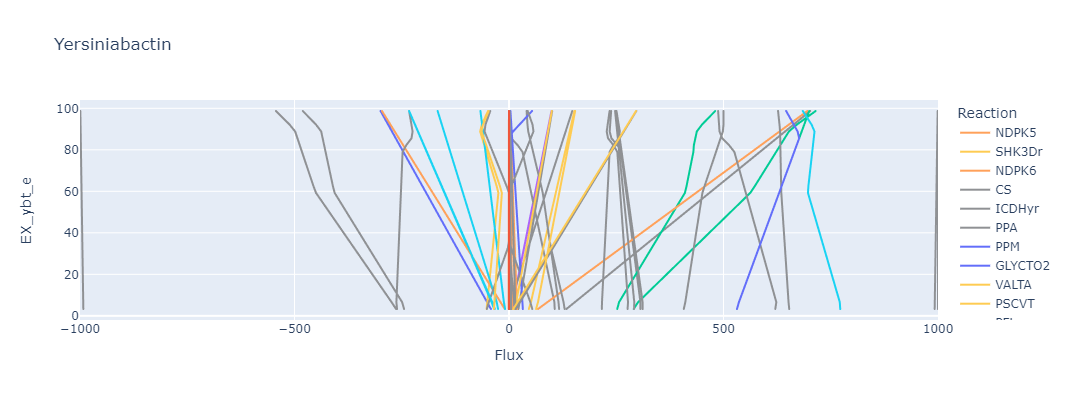

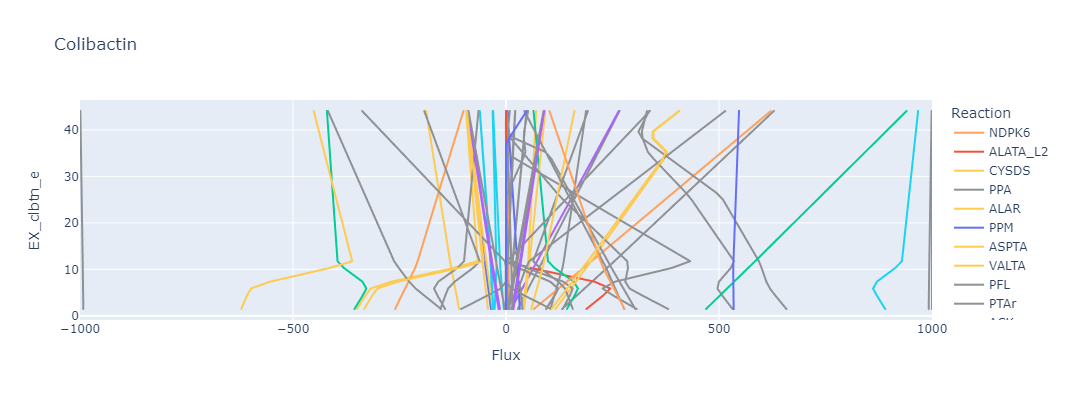

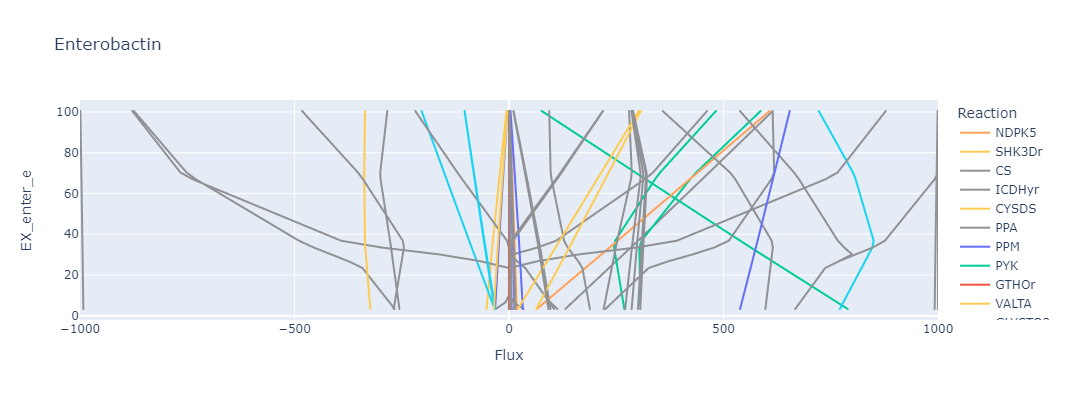

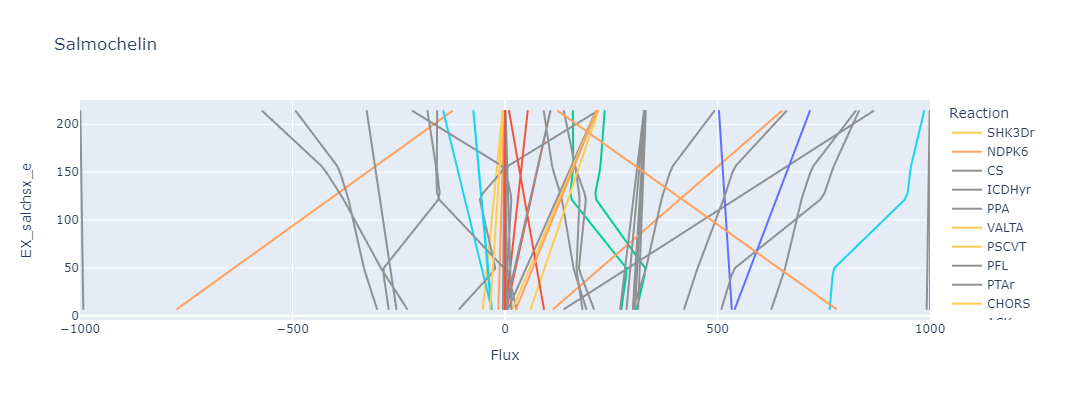

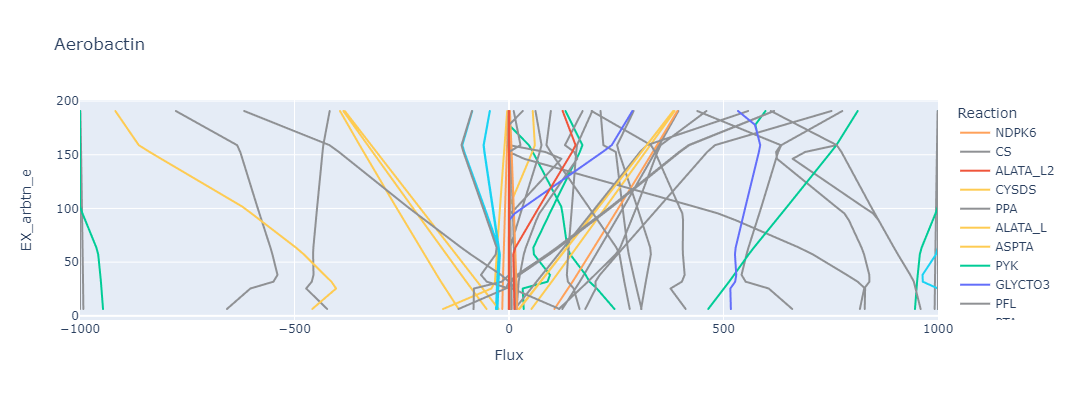

In [55]:
for sec_met in fseof_dict.keys():
    df = fseof_dict[sec_met].T
    target_exchange = target_exchange_dict[sec_met]

    flux_list = []
    target_exchange_flux = []
    reaction_list = []
    subsystem_list = []
    diff_2_list = []

    for rxn_id in df.columns:
        if target_exchange not in rxn_id:
            flux_list = flux_list + df[rxn_id].tolist()
            target_exchange_flux = target_exchange_flux + df[target_exchange].tolist()
            reaction_list = reaction_list + [rxn_id]*df.shape[0]
            subsystem_list = subsystem_list + [df_reactions.loc[rxn_id, 'Subsystem']]*df.shape[0]
            diff_2_list =diff_2_list + [df_diff_2.loc[rxn_id, sec_met]]*df.shape[0]

    df_line = pd.DataFrame(columns=['Flux', target_exchange, 'Reaction', 'Subsystem', 'diff_2'])

    df_line['Flux'] = flux_list
    df_line[target_exchange] = target_exchange_flux
    df_line['Reaction'] = reaction_list
    df_line['Subsystem'] = subsystem_list
    df_line['diff_2'] = diff_2_list
    
    df_plot = df_line.copy()
    
    for idx in df_plot.index:
        subsys = df_plot.loc[idx, 'Subsystem']
        if subsys in color_dict.keys():
            df_plot.loc[idx, 'color'] = color_dict[subsys]
        else:
            df_plot.loc[idx,'color'] = color_dict['Other']
  
    
    fig = px.line(df_plot, width=800, height=400, y=target_exchange, x='Flux', title=sec_met, range_x=[-1000,1000],
                  color='Reaction', hover_data=df_plot, color_discrete_map=dict(zip(df_plot.Reaction, df_plot.color)))
    fig.show()
    fig.write_image('../figures/fseof/' + sec_met + '.svg')

In [56]:
excel_path = '../tables/DataS4.xlsx'

with pd.ExcelWriter(excel_path, mode='w') as writer:  
    for sec_met in fseof_dict.keys():
        print(sec_met)
        df_tmp_fseof = fseof_dict[sec_met]
        for rxn in df_tmp_fseof.index:
            if rxn in df_reactions.index:
                df_tmp_fseof.loc[rxn,'Name'] = df_reactions.loc[rxn, 'Name']
                df_tmp_fseof.loc[rxn,'Subsystem'] = df_reactions.loc[rxn, 'Subsystem']
        df_tmp_fseof.sort_values(by='Subsystem', inplace=True)
        df_tmp_fseof.to_excel(writer, sheet_name=sec_met)
    
    df_fseof_tgt_slopes['Name'] = df_reactions.loc[df_fseof_tgt_slopes.index, 'Name']
    df_fseof_tgt_slopes['Subsystem'] = df_reactions.loc[df_fseof_tgt_slopes.index, 'Subsystem']
    df_fseof_tgt_slopes.sort_values(by='Subsystem', inplace=True)
    df_fseof_tgt_slopes.to_excel(writer, sheet_name='Slopes')
    
    df_diff_2['Name'] = df_reactions.loc[df_diff_2.index, 'Name']
    df_diff_2['Subsystem'] = df_reactions.loc[df_diff_2.index, 'Subsystem']
    df_diff_2.sort_values(by='Subsystem', inplace=True)
    df_diff_2.to_excel(writer, sheet_name='Second derivative')

Yersiniabactin
Colibactin
Enterobactin
Salmochelin
Aerobactin


In [59]:
df_fseof_tgt_slopes_sorted = df_fseof_tgt_slopes.sort_values(by=df_diff_1.columns.tolist())

In [60]:
for sec_met in df_diff_1.columns:
    print(sec_met,df_fseof_tgt_slopes_sorted[sec_met].dropna().shape)

Yersiniabactin (98,)
Colibactin (123,)
Enterobactin (91,)
Salmochelin (85,)
Aerobactin (106,)


In [62]:
df_fseof_tgt_slopes_common = pd.DataFrame(columns=df_fseof_tgt_slopes.columns)
for rxn_id in df_fseof_tgt_slopes_sorted.index:
    if df_diff_1.loc[rxn_id, :].isna().sum() == 0:
        df_fseof_tgt_slopes_common.loc[rxn_id,:] = df_fseof_tgt_slopes_sorted.loc[rxn_id, :]

In [64]:
df_fseof_tgt_slopes_unique = pd.DataFrame(columns=df_fseof_tgt_slopes.columns)

for rxn_id in df_fseof_tgt_slopes_sorted.index:
    if df_diff_1.loc[rxn_id, :].isna().sum() == 4:
        df_fseof_tgt_slopes_unique.loc[rxn_id,:] = df_fseof_tgt_slopes_sorted.loc[rxn_id, :]

In [269]:
df_fseof_subsystem_count 

Yersiniabactin  \
Subsystem                                                            
Transport, Outer Membrane                                        8   
Nucleotide Salvage Pathway                                      11   
Pentose Phosphate Pathway                                        9   
Transport, Inner Membrane                                        8   
Alternate Carbon Metabolism                                      8   
Cofactor and Prosthetic Group Biosynthesis                       4   
Citric Acid Cycle                                                8   
Membrane Lipid Metabolism                                        1   
Inorganic Ion Transport and Metabolism                           4   
Oxidative Phosphorylation                                        3   
Glycolysis/Gluconeogenesis                                       5   
Tyrosine, Tryptophan, and Phenylalanine Metabolism               7   
Pyruvate Metabolism                                              3   
Glycine and Serine Metabolism                                    4   
Threonine and Lysine Metabolism                                  0   
Methionine Metabolism                                            6   
Nitrogen Metabolism                                              1   
Anaplerotic Reactions                                            2   
Valine, Leucine, and Isoleucine Metabolism                       2   
Unassigned                                                       1   
Folate Metabolism                                                2   
Purine and Pyrimidine Biosynthesis                               1   
Alanine and Aspartate Metabolism                                 0   
Glutamate Metabolism                                             0   
Cysteine Metabolism                                              0   
Arginine and Proline Metabolism                                  0   
Cell Envelope Biosynthesis                                       0   

                                                    Colibactin  Enterobactin  \
Subsystem                                                                      
Transport, Outer Membrane                                   10            10   
Nucleotide Salvage Pathway                                  10             9   
Pentose Phosphate Pathway                                    9             7   
Transport, Inner Membrane                                    8             7   
Alternate Carbon Metabolism                                  8             7   
Cofactor and Prosthetic Group Biosynthesis                   5             4   
Citric Acid Cycle                                            1             8   
Membrane Lipid Metabolism                                   25             0   
Inorganic Ion Transport and Metabolism                       5             5   
Oxidative Phosphorylation                                    4             5   
Glycolysis/Gluconeogenesis                                   3             4   
Tyrosine, Tryptophan, and Phenylalanine Metabolism           0             7   
Pyruvate Metabolism                                          4             3   
Glycine and Serine Metabolism                                4             3   
Threonine and Lysine Metabolism                              3             0   
Methionine Metabolism                                        5             0   
Nitrogen Metabolism                                          2             3   
Anaplerotic Reactions                                        2             2   
Valine, Leucine, and Isoleucine Metabolism                   2             2   
Unassigned                                                   3             1   
Folate Metabolism                                            2             0   
Purine and Pyrimidine Biosynthesis                           1             1   
Alanine and Aspartate Metabolism                             2             0   
Glutamate Metabolism 

# Flux variability analysis

In [223]:
# Create FVA tables directories for each sec met 
rxns_selected = [rxn_id.id for rxn_id in EcN_model.reactions]
for sec_met in target_exchange_dict.keys():
    try:
        os.mkdir("../tables/sec_met_fva/" + sec_met)
    except FileExistsError:
        pass
    
    target_exchange = target_exchange_dict[sec_met]
    FVA_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 
    for FVA_value in FVA_range:
        flux_df = pd.DataFrame(index=rxns_selected, columns=['lb', 'ub', 'pfba_wt', 'pfba_sec_met'])
        
        model_wt = EcN_model.copy()
        
        model_tgt = EcN_model.copy()
        model_tgt.objective = target_exchange
        
        # Set FVA value as growth boundaries
        growth = FVA_value*model_wt.optimize().objective_value
        model_tgt.reactions.BIOMASS_EcN_iHM1533_core_59p80M.bounds = (growth,growth)
        model_wt.reactions.BIOMASS_EcN_iHM1533_core_59p80M.bounds = (growth,growth)
        
        pfba_solution_wt = cobra.flux_analysis.pfba(model_wt)
        pfba_solution_tgt = cobra.flux_analysis.pfba(model_tgt)

        bounds = flux_variability_analysis(model_tgt, rxns_selected)
        
        flux_df.loc[rxns_selected, 'lb'] = bounds.loc[rxns_selected, 'minimum']
        flux_df.loc[rxns_selected, 'ub'] = bounds.loc[rxns_selected, 'maximum']
        flux_df.loc[rxns_selected, 'pfba_wt'] = pfba_solution_wt.to_frame().loc[rxns_selected, 'fluxes']
        flux_df.loc[rxns_selected, 'pfba_sec_met'] = pfba_solution_tgt.to_frame().loc[rxns_selected, 'fluxes']
        flux_df.index.name = "ID"
        print('Maximum flux through', target_exchange, pfba_solution_tgt[target_exchange], FVA_value, growth)        
        flux_df.to_csv(os.path.join("../tables/sec_met_fva/", sec_met, "df_fva_sec_met_" + str(FVA_value) + ".csv"))

Maximum flux through EX_ybt_e 109.66395604395562 0 0.0
Maximum flux through EX_ybt_e 98.70966642371624 0.1 3.5554087475828187
Maximum flux through EX_clbtn_e 48.96664664664568 0 0.0
Maximum flux through EX_clbtn_e 44.34818183640887 0.1 3.5554087475828187
Maximum flux through EX_enter_e 111.61213572854348 0 0.0
Maximum flux through EX_enter_e 101.34830397174316 0.1 3.5554087475828187
Maximum flux through EX_salchsx_e 237.60523809523806 0 0.0
Maximum flux through EX_salchsx_e 213.84471428571146 0.1 3.5554087475828187
Maximum flux through EX_arbtn_e 211.92518297236734 0 0.0
Maximum flux through EX_arbtn_e 194.20491758303876 0.1 3.5554087475828187


In [211]:
rxns_selected = [rxn_id.id for rxn_id in EcN_model.reactions]
for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met]
    pfba_flux_df = pd.DataFrame(index=rxns_selected, columns=['pfba_wt', 'pfba_sec_met'])
    model_wt = EcN_model.copy()
    model_tgt = EcN_model.copy()
    model_tgt.objective = target_exchange
    
    growth = model_wt.optimize().objective_value
    tgt_flux = model_tgt.optimize().objective_value
    
    model_wt.reactions.BIOMASS_EcN_iHM1533_core_59p80M.bounds = (growth,growth)
    model_tgt.reactions.get_by_any(target_exchange)[0].bounds = (tgt_flux,tgt_flux)
        
    pfba_solution_wt = cobra.flux_analysis.pfba(model_wt)
    pfba_solution_tgt = cobra.flux_analysis.pfba(model_tgt)

    pfba_flux_df.loc[rxns_selected, 'pfba_wt'] = pfba_solution_wt.to_frame().loc[rxns_selected, 'fluxes']
    pfba_flux_df.loc[rxns_selected, 'pfba_sec_met'] = pfba_solution_tgt.to_frame().loc[rxns_selected, 'fluxes']
    pfba_flux_df.index.name = "ID"
    pfba_flux_df.to_csv(os.path.join("../tables/sec_met_fva/", sec_met, "df_pfba_sec_met.csv"))

In [265]:
selected_reactions_dict = dict()
for sec_met in target_exchange_dict.keys():
    selected_reactions_dict[sec_met] = df_fseof_tgt_slopes_sorted[sec_met].dropna().sort_values().index.tolist()[:10] + df_fseof_tgt_slopes_sorted[sec_met].dropna().sort_values().index.tolist()[-10:]

In [266]:
FVA_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 
for sec_met in target_exchange_dict.keys():
    rxns_selected = selected_reactions_dict[sec_met]
    pfba_flux_df = pd.read_csv(os.path.join("../tables/sec_met_fva/", sec_met, "df_pfba_sec_met.csv"), index_col=0)
    for FVA_value in FVA_range:
        flux_df = pd.read_csv(os.path.join("../tables/sec_met_fva/", sec_met, "df_fva_sec_met_" + str(FVA_value) + ".csv"), index_col=0)
        selected_flux_df = flux_df.loc[rxns_selected,:]
        selected_flux_df.to_csv(os.path.join("../tables/sec_met_fva/", sec_met, "df_fva_sec_met_selected_" + str(FVA_value) + ".csv"))
    selected_pfba_flux_df = pfba_flux_df.loc[rxns_selected,:]
    selected_pfba_flux_df.to_csv(os.path.join("../tables/sec_met_fva/", sec_met, "df_pfba_sec_met_selected.csv"))

In [250]:
unique_reactions_dict = dict()
for sec_met in target_exchange_dict.keys():
    unique_reactions_dict[sec_met] = df_fseof_tgt_slopes_unique[sec_met].dropna().sort_values().index.tolist()

FVA_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 
for sec_met in target_exchange_dict.keys():
    rxns_selected = unique_reactions_dict[sec_met]
    for FVA_value in FVA_range:
        flux_df = pd.read_csv(os.path.join("../tables/sec_met_fva/", sec_met, "df_fva_sec_met_" + str(FVA_value) + ".csv"), index_col=0)
        selected_flux_df = flux_df.loc[rxns_selected,:]
        selected_flux_df['Subsystem'] = df_reactions.loc[selected_flux_df.index, 'Subsystem']
        selected_flux_df['Color'] = [color_dict[subsys] if subsys in color_dict.keys() else color_dict['Other'] for subsys in selected_flux_df.Subsystem.tolist() ]

        selected_flux_df.to_csv(os.path.join("../tables/sec_met_fva/", sec_met, "df_fva_sec_met_unique_" + str(FVA_value) + ".csv"))

In [230]:
df_fseof_tgt_slopes_common = df_fseof_tgt_slopes_common.sort_values(by=['Subsystem','Yersiniabactin'])

In [248]:
common_reactions = df_fseof_tgt_slopes_common.index.tolist()
FVA_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 
for sec_met in target_exchange_dict.keys():
    rxns_selected = common_reactions
    for FVA_value in FVA_range:
        flux_df = pd.read_csv(os.path.join("../tables/sec_met_fva/", sec_met, "df_fva_sec_met_" + str(FVA_value) + ".csv"), index_col=0)
        selected_flux_df = flux_df.loc[rxns_selected,:]
        selected_flux_df['Subsystem'] = df_reactions.loc[selected_flux_df.index, 'Subsystem']
        selected_flux_df['Color'] = [color_dict[subsys] if subsys in color_dict.keys() else color_dict['Other'] for subsys in selected_flux_df.Subsystem.tolist() ]

        selected_flux_df.to_csv(os.path.join("../tables/sec_met_fva/", sec_met, "df_fva_sec_met_common_" + str(FVA_value) + ".csv"))